Loading and preprocessing data...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9b419149a0>
Traceback (most recent call last):
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 's

Performing causal discovery using FCI algorithm...


  0%|          | 0/53 [00:00<?, ?it/s]

X3 --> X2
X27 --> X2
X41 --> X3
X7 --> X13
X8 --> X45
X35 --> X10
X10 --> X47
X11 --> X35
X27 --> X14
X17 --> X42
X20 --> X21
X32 --> X20
X27 --> X33
X27 --> X38
X29 --> X41
X36 --> X35
X38 --> X37
X52 --> X42
X45 --> X53


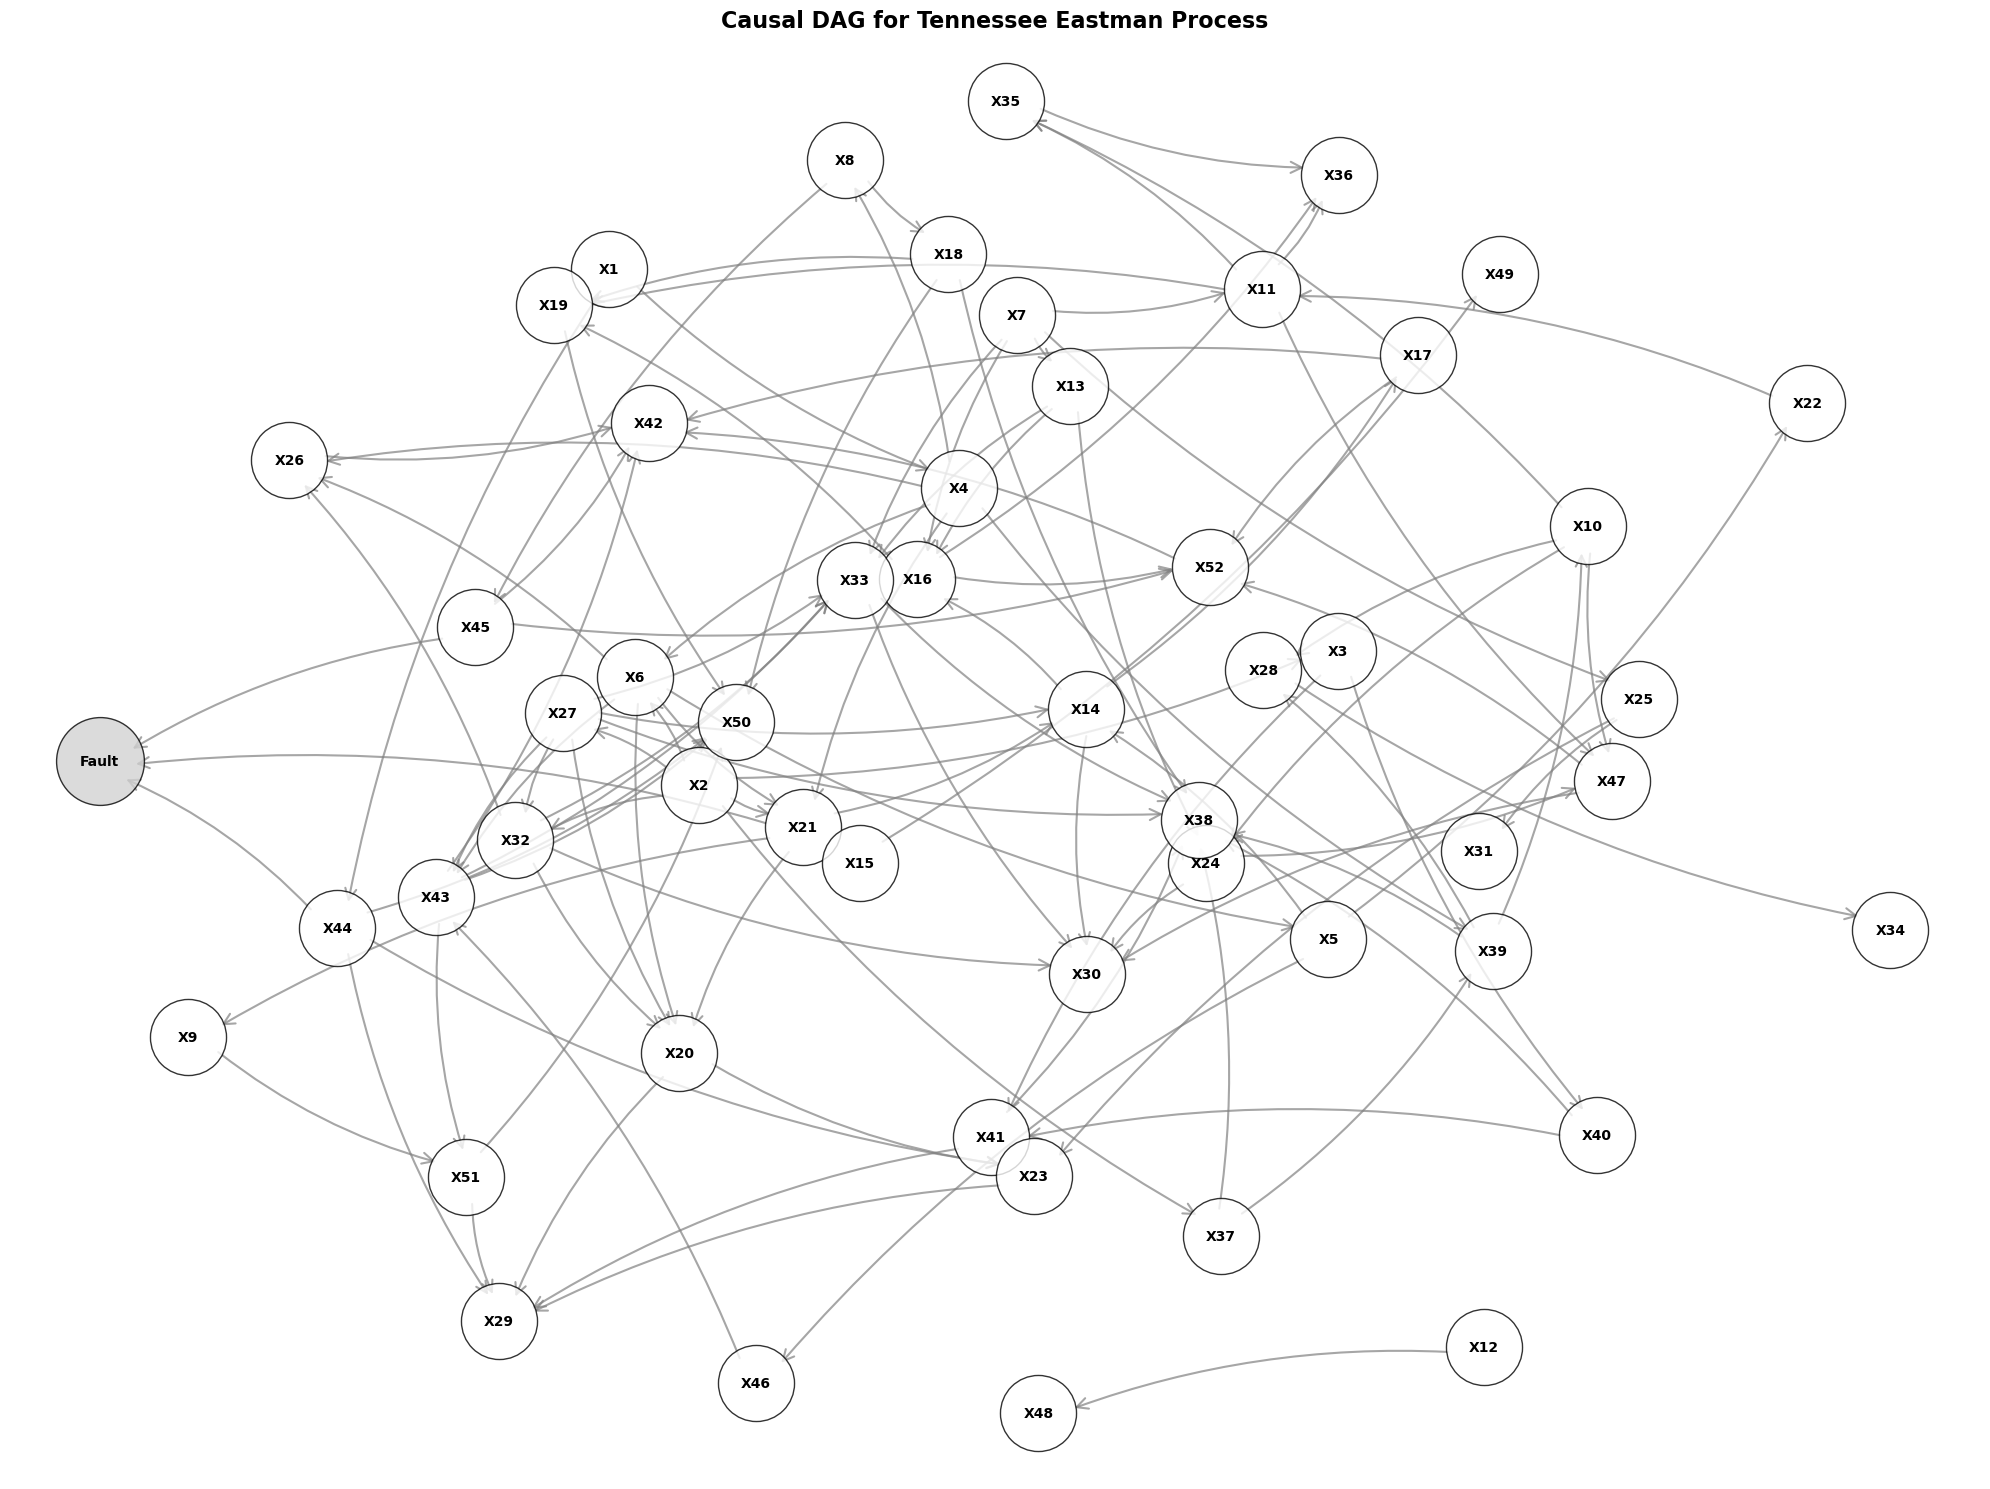

Edges in the causal graph:
X1 --> X4
X1 --> X44
X4 --> X6
X4 --> X8
X4 --> X21
X4 --> X26
X4 --> X39
X44 --> X23
X44 --> X29
X44 --> X50
X44 --> Fault
X2 --> X3
X2 --> X6
X2 --> X21
X2 --> X27
X2 --> X32
X2 --> X37
X3 --> X40
X3 --> X41
X6 --> X5
X6 --> X20
X6 --> X21
X6 --> X26
X6 --> X43
X21 --> X9
X21 --> X14
X21 --> X20
X21 --> Fault
X27 --> X14
X27 --> X20
X27 --> X32
X27 --> X33
X27 --> X38
X27 --> X43
X32 --> X20
X32 --> X26
X32 --> X30
X32 --> X33
X37 --> X38
X37 --> X39
X40 --> X38
X40 --> X41
X41 --> X29
X41 --> X38
X8 --> X18
X8 --> X45
X26 --> X42
X39 --> X10
X39 --> X28
X39 --> X38
X5 --> X14
X5 --> X22
X5 --> X46
X14 --> X16
X14 --> X17
X14 --> X30
X22 --> X11
X46 --> X43
X20 --> X23
X20 --> X29
X43 --> X33
X43 --> X42
X43 --> X50
X43 --> X51
X7 --> X11
X7 --> X13
X7 --> X16
X7 --> X25
X7 --> X33
X11 --> X19
X11 --> X35
X11 --> X36
X11 --> X47
X13 --> X16
X13 --> X24
X13 --> X33
X16 --> X19
X16 --> X36
X16 --> X52
X25 --> X23
X25 --> X31
X33 --> X30
X33 --> X38
X18 --> X1

/tmp/ipykernel_100963/3045338793.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


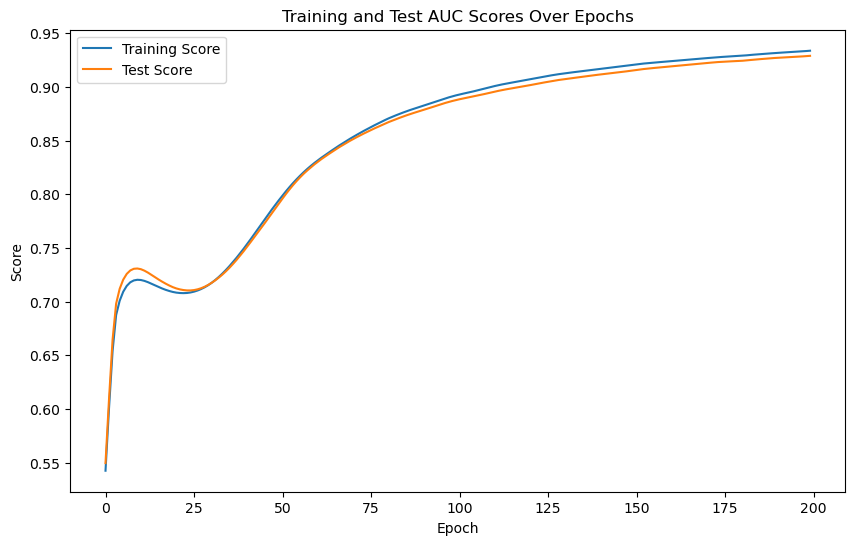

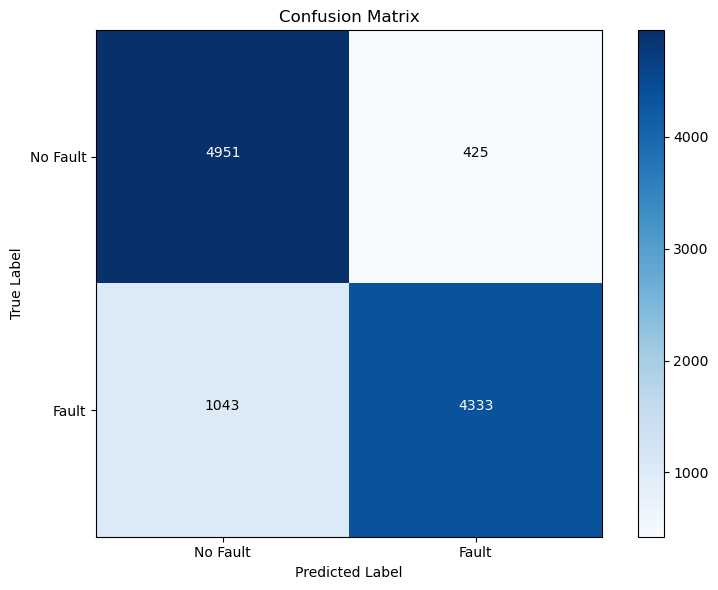

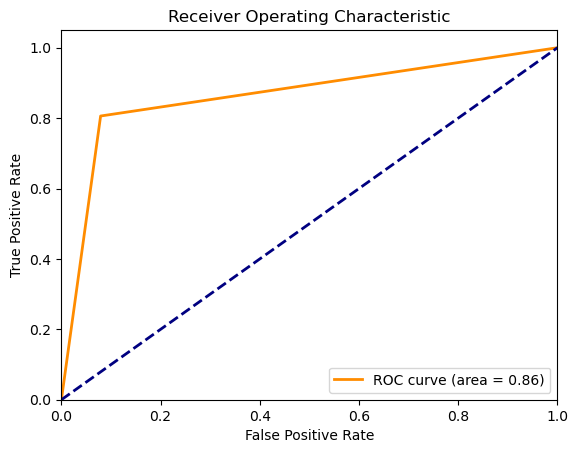

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (balanced_accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             matthews_corrcoef, log_loss, roc_curve, auc)
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.loader import DataLoader
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.GeneralGraph import GeneralGraph
import networkx as nx

torch.manual_seed(42)
np.random.seed(42)

# Define the path to the dataset
data_path = 'Documents/tennessee-eastmen-process-classification/TE_process/data/'

def load_data(file_path):
    data = pd.read_csv(file_path, sep=r'\s+', header=None)
    return data.values

def create_dataset():
    X = []
    y = []
    
    for i in range(22):
        train_file = os.path.join(data_path, f'd{i:02d}.dat')
        train_data = load_data(train_file)
        X.append(train_data)
        y.append(np.full(train_data.shape[0], 1 if i > 0 else 0))
        
        test_file = os.path.join(data_path, f'd{i:02d}_te.dat')
        test_data = load_data(test_file)
        X.append(test_data)
        if i == 0:
            y.append(np.zeros(test_data.shape[0]))
        else:
            y.append(np.concatenate([np.zeros(160), np.ones(test_data.shape[0] - 160)]))
    
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

def plot_causal_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
    plt.title("Causal Graph of Variables")
    plt.show()

def general_graph_to_networkx(g: GeneralGraph) -> nx.Graph:
    G = nx.Graph()
    n_nodes = g.get_nodes().__len__()
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if g.graph[i, j] != 0:  # If there's an edge
                G.add_edge(i, j)
    return G

def create_directed_edge_index(G, num_nodes):
    edge_index = []
    edge_attr = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
        edge_attr.append([1, 0])  # [1, 0] represents a forward edge
        edge_index.append([edge[1], edge[0]])
        edge_attr.append([0, 1])  # [0, 1] represents a backward edge
    return (torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            torch.tensor(edge_attr, dtype=torch.float))

class DirectedGNN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(DirectedGNN, self).__init__()
        self.conv1 = GATv2Conv(num_features, hidden_channels, edge_dim=2)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels // 2, edge_dim=2)
        self.fc = nn.Linear(hidden_channels // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.fc(x)
        return torch.sigmoid(x)

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    out_probs = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr).squeeze()
            out_probs.extend(out.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    
    # Find optimal threshold
    fpr, tpr, thresholds = roc_curve(targets, out_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    predictions = (np.array(out_probs) > optimal_threshold).astype(int)
    
    return (balanced_accuracy_score(targets, predictions), 
            precision_score(targets, predictions), 
            recall_score(targets, predictions), 
            f1_score(targets, predictions),
            matthews_corrcoef(targets, predictions), 
            roc_auc_score(targets, out_probs),
            log_loss(targets, out_probs), 
            predictions, targets, optimal_threshold)

def create_causal_dag_with_output(X, y):
    # Combine X and y for FCI algorithm
    data_with_output = np.column_stack((X, y))
    
    # Run FCI algorithm
    fci_result = fci(data_with_output)
    general_graph = fci_result[0]
    
    # Convert to NetworkX graph
    G = general_graph_to_networkx(general_graph)
    
    return G

def plot_professional_causal_dag(G, num_features):
    plt.figure(figsize=(20, 15))
    
    actual_nodes = list(G.nodes())
    feature_nodes = [node for node in actual_nodes if node < num_features]
    output_node = max(actual_nodes)
    
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    # Draw nodes
    feature_nodes_circles = nx.draw_networkx_nodes(G, pos, nodelist=feature_nodes, node_color='white', 
                                                   edgecolors='black', node_size=3000, alpha=0.8)
    output_node_circle = nx.draw_networkx_nodes(G, pos, nodelist=[output_node], node_color='lightgray', 
                                                edgecolors='black', node_size=4000, alpha=0.8)
    
    # Add node labels
    node_labels = {i: f"X{i+1}" for i in feature_nodes}
    node_labels[output_node] = 'Fault'
    nx.draw_networkx_labels(G, pos, node_labels, font_size=10, font_weight='bold')
    
    # Function to get edge connection points
    def get_connection_points(start_pos, end_pos, radius):
        angle = np.arctan2(end_pos[1] - start_pos[1], end_pos[0] - start_pos[0])
        start_point = (start_pos[0] + radius * np.cos(angle),
                       start_pos[1] + radius * np.sin(angle))
        end_point = (end_pos[0] - radius * np.cos(angle),
                     end_pos[1] - radius * np.sin(angle))
        return start_point, end_point
    
    # Draw edges with arrows
    for edge in G.edges():
        start_node, end_node = edge
        start_pos, end_pos = pos[start_node], pos[end_node]
        
        # Adjust radius based on node type (feature or output)
        start_radius = 0.04 if start_node != output_node else 0.05
        end_radius = 0.04 if end_node != output_node else 0.05
        
        start_point, end_point = get_connection_points(start_pos, end_pos, start_radius)
        
        arrow = ConnectionPatch(start_point, end_point, 'data', 'data', arrowstyle='->', 
                                mutation_scale=20, lw=1.5, alpha=0.7, color='gray',
                                connectionstyle='arc3,rad=0.1')
        plt.gca().add_patch(arrow)
    
    plt.title("Causal DAG for Tennessee Eastman Process", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing data...")
    X, y = create_dataset()
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print("Performing causal discovery using FCI algorithm...")
    G = create_causal_dag_with_output(X_resampled, y_resampled)
    plot_professional_causal_dag(G, X_resampled.shape[1])
    
    # Print the edges of the graph
    print("Edges in the causal graph:")
    for edge in G.edges():
        print(f"X{edge[0]+1} --> X{edge[1]+1}" if edge[1] < X_resampled.shape[1] else f"X{edge[0]+1} --> Fault")
    
    edge_index, edge_attr = create_directed_edge_index(G, X_resampled.shape[1])
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    train_data = Data(x=torch.tensor(X_train, dtype=torch.float32),
                      edge_index=edge_index,
                      edge_attr=edge_attr,
                      y=torch.tensor(y_train, dtype=torch.float32))
    test_data = Data(x=torch.tensor(X_test, dtype=torch.float32),
                     edge_index=edge_index,
                     edge_attr=edge_attr,
                     y=torch.tensor(y_test, dtype=torch.float32))
    
    train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DirectedGNN(num_features=X_resampled.shape[1], hidden_channels=128).to(device)
    
    # Use BCEWithLogitsLoss instead of FocalLoss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    num_epochs = 200
    patience = 70
    best_auc = 0
    counter = 0
    train_auc_scores = []
    test_auc_scores = []
    
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        _, _, _, _, _, train_auc, _, _, _, _ = evaluate_model(model, train_loader, device)
        test_bal_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets, threshold = evaluate_model(model, test_loader, device)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}')
        
        train_auc_scores.append(train_auc)
        test_auc_scores.append(test_auc)
        
        # Early stopping based on AUC
        if test_auc > best_auc:
            best_auc = test_auc
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            best_threshold = threshold
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Final evaluation
    test_bal_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets, _ = evaluate_model(model, test_loader, device)
    print(f"Final Test Results: Balanced Accuracy: {test_bal_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}, AUC: {test_auc:.4f}, Log Loss: {test_logloss:.4f}")
    
    plot_training_history(train_auc_scores, test_auc_scores, "Training and Test AUC Scores Over Epochs")
    plot_confusion_matrix(test_targets, test_preds)
    plot_roc_curve(test_targets, test_preds)

if __name__ == '__main__':
    main()
